# Lab 3: The geometry of two views

In this lab you will learn how to estimate the fundamental matrix that relates two images, corresponding to two different views of the same scene, given a set of correspondences between them. Then, you will apply the estimation of the fundamental matrix to solve the photo-sequencing problem.

The following file combines some text cells (Markdown cells) and code cells. Some parts of the code need to be completed. All tasks you need to complete are marked in <span style='color:Green'> green.  </span>

In [ ]:
!apt-get update
!apt-get install ffmpeg libsm6 libxext6  -y
!pip install opencv-python

Get:1 http://deb.debian.org/debian buster InRelease [122 kB]
Get:2 http://security.debian.org/debian-security buster/updates InRelease [65.4 kB]
Get:3 http://deb.debian.org/debian buster-updates InRelease [51.9 kB]
Get:4 http://security.debian.org/debian-security buster/updates/main amd64 Packages [312 kB]
Get:5 http://deb.debian.org/debian buster/main amd64 Packages [7,906 kB]
Get:6 http://deb.debian.org/debian buster-updates/main amd64 Packages [8,792 B]
Fetched 8,466 kB in 2s (4,553 kB/s)




libsm6 is already the newest version (2:1.2.3-1).
libsm6 set to manually installed.
libxext6 is already the newest version (2:1.3.3-1+b2).
libxext6 set to manually installed.
The following additional packages will be installed:
  i965-va-driver intel-media-va-driver libaacs0 libaom0 libasound2
  libasound2-data libass9 libasyncns0 libavc1394-0 libavcodec58 libavdevice58
  libavfilter7 libavformat58 libavresample4 libavutil56 libbdplus0 libbluray2
  libbs2b0 libcaca0 libcap2 libcdio-cdda2 libcdi

In [ ]:
import numpy as np
from numpy import linalg as LA
import cv2
import math
import sys
import random
import matplotlib
from matplotlib import pyplot as plt
from operator import itemgetter

## **1. Estimation of the fundamental matrix**

### **1.1 DLT algorithm**

The first task is to create the function that estimates the fundamental matrix given a set of point correspondences between a pair of images.

<span style='color:Green'> - Complete the function "fundamental_matrix" below.  </span>

In [ ]:
def normalization_H(points):
    centroid_T = np.mean(points[:-1, :], axis=1)
    points_centered = points[:-1, :] - centroid_T.reshape(2, 1)
    scale_T = 2**0.5 / np.mean((points_centered[0, :]**2 + points_centered[1, :]**2)**0.5)

    T = np.array([
        [scale_T, 0, -scale_T*centroid_T[0]],
        [0, scale_T, -scale_T*centroid_T[1]],
        [0, 0, 1]
    ])

    return T

def Normalise_last_coord(x):
    xn = x  / x[2,:]
    return xn

def fundamental_matrix(points1, points2, log=True):
    
    # Set last coordinate to 1
    points1, points2 = Normalise_last_coord(points1), Normalise_last_coord(points2)

    # Normalize points
    H1, H2 = normalization_H(points1), normalization_H(points2)
    points1_n, points2_n = H1 @ points1, H2 @ points2
    points1_n, points2_n = Normalise_last_coord(points1_n), Normalise_last_coord(points2_n)

    # Compute matrix W to obtain f 
    W = []
    for idx in range(points1.shape[1]):
        p1, p2 = points1_n[:, idx], points2_n[:, idx]
        u, v, _ = p1
        u_p, v_p, _ = p2
        W.append([u*u_p, v*u_p, u_p, u*v_p, v*v_p, v_p, u, v, 1])
    W = np.array(W)

    U,D,Vt = np.linalg.svd(W)
    F_rank3 = Vt[-1, :].reshape(3, 3)
    if log:  print("rank 3 F: ", F_rank3, "\n")

    # Convert F to rank 2
    U, D, Vt = np.linalg.svd(F_rank3)
    D = np.diag(D)
    if log:  print("D before:", D, "\n")
    D[2, 2] = 0
    if log:  print("D after:", D, "\n")
    F_rank2 = U @ D @ Vt
    if log:  print("rank 2 F: ", F_rank2, "\n")

    # Denormalize F
    F = H2.T @ F_rank2 @ H1

    return F

In order to check that the completed function works properly you may use this code which is a toy example where we know the ground truth image.

<span style='color:Green'> - Complete the expression of the ground truth fundamental matrix.  </span>

In [ ]:
# Two camera matrices for testing purposes
P1 = np.zeros((3,4))
P1[0,0]=P1[1,1]=P1[2,2]=1

angle = 15
theta = np.radians(angle)
c = np.cos(theta)
s = np.sin(theta)
R = np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])
t = np.array([[.3, .1, .2]])

P2 = np.concatenate((R, t.T), axis=1)

n = 8
rand = np.random.uniform(0,1,n)
rand = rand.reshape((1, n))
rand2 = np.random.uniform(0,1,2*n)
rand2 = rand2.reshape((2, n))
ones = np.ones((1,n))
X = np.concatenate((rand2, 3*rand, ones), axis=0)

x1_test = P1 @ X
x2_test = P2 @ X

# Estimate fundamental matrix (you need to create this function)
F_es = fundamental_matrix(x1_test, x2_test)

# Ground truth fundamental matrix 
def skew_symm(v):
    return np.array([[0, -v[2], v[1]], 
                     [v[2], 0, -v[0]], 
                     [-v[1], v[0], 0]])

F_gt = skew_symm(-t.reshape(-1)) @ R


# Evaluation: these two matrices should be very similar
F_gt = np.sign(F_gt[0,0])*F_gt / LA.norm(F_gt)
F_es = np.sign(F_es[0,0])*F_es / LA.norm(F_es)

print("Grountruth:")
print(F_gt)
print("Estimated fundamental matrix:")
print(F_es)
print("Difference:")
print(LA.norm(F_gt-F_es))

rank 3 F:  [[-0.04167114 -0.15551882  0.01768156]
 [ 0.15551882 -0.04167114 -0.73439285]
 [ 0.13604381  0.62119264  0.06419592]] 

D before: [[7.62511950e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.46974130e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.95847414e-16]] 

D after: [[0.76251195 0.         0.        ]
 [0.         0.64697413 0.        ]
 [0.         0.         0.        ]] 

rank 2 F:  [[-0.04167114 -0.15551882  0.01768156]
 [ 0.15551882 -0.04167114 -0.73439285]
 [ 0.13604381  0.62119264  0.06419592]] 

Grountruth:
[[ 0.0978244   0.36508565 -0.18898224]
 [-0.36508565  0.0978244   0.56694671]
 [ 0.03580622 -0.59654067  0.        ]]
Estimated fundamental matrix:
[[ 9.78244040e-02  3.65085646e-01 -1.88982237e-01]
 [-3.65085646e-01  9.78244040e-02  5.66946710e-01]
 [ 3.58062170e-02 -5.96540671e-01  3.78944460e-16]]
Difference:
4.944035835840744e-15


### **1.2 Robust estimation of the fundamental matrix**

The goal of this section is to estimate the fundamental matrix in a practical situation where the image correspondences contain outliers. For that you will have to write the code of the robust version of the previous algorithm.

We will start by computing and visualizing the image matches.

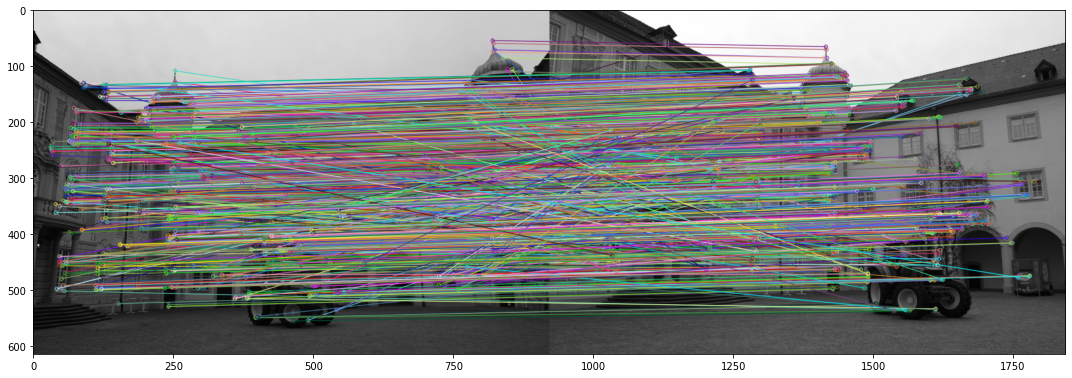

In [ ]:
# Compute inage correspondences #

# Read images
img1 = cv2.imread('Data/0000_s.png',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('Data/0001_s.png',cv2.IMREAD_GRAYSCALE)

# Initiate ORB detector
orb = cv2.ORB_create(3000)
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# Keypoint matching
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1,des2)

# Show "good" matches
img_12 = cv2.drawMatches(img1,kp1,img2,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_12)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

<span style='color:Green'> - Write the function Ransac_fundamental_matrix that embeds in a RANSAC procedure the previous DLT algorithm for estimating the fundamental matrix. You may use the provided RANSAC function in lab 2 as a starting point.  </span>

Note: In order not to end up, eventually, in an infinite loop, it is recommended to set, at each iteration, the maximum number of iterarions to the maximum between a predefined maximum number of iterations by the user and the automatically estimated max. number of iterarions. The estimated number of iterations ensures we pick, with a probability of 0.99, an initial set of correspondences with no outliers.

In [ ]:
def Inliers(F, points1, points2, th):

    # Compute Sampson distances
    num = np.sum(points2 * (F @ points1), axis=0)**2
    den = (F @ points1)[0]**2 + (F @ points1)[1]**2
    den += (F.T @ points2)[0]**2 + (F.T @ points2)[1]**2
    sampson_dist = num/den

    # Find inliers
    inliers = np.where(sampson_dist < th)[0]
    return inliers


def Ransac_fundamental_matrix(points1, points2, th, max_it_0):
    
    Ncoords, Npts = points1.shape
    
    it = 0
    best_inliers = np.empty(1)
    
    max_it = max_it_0
    while it < min(max_it, max_it_0):
        indices = random.sample(range(1, Npts), 8)
        F = fundamental_matrix(points1[:,indices], points2[:,indices], log=False)
        inliers = Inliers(F, points1, points2, th)
        
        # test if it is the best model so far
        if inliers.shape[0] > best_inliers.shape[0]:
            best_inliers = inliers
        
        # update estimate of iterations (the number of trials) to ensure we pick, with probability p,
        # an initial data set with no outliers
        fracinliers = inliers.shape[0]/Npts
        pNoOutliers = 1 -  fracinliers**8
        eps = sys.float_info.epsilon
        pNoOutliers = max(eps, pNoOutliers)   # avoid division by -Inf
        pNoOutliers = min(1-eps, pNoOutliers) # avoid division by 0
        p = 0.99
        max_it = math.log(1-p)/math.log(pNoOutliers)

        it += 1

    # compute F from all the inliers
    F = fundamental_matrix(points1[:,best_inliers], points2[:,best_inliers], log=False)
    inliers = best_inliers  # F could be improved iteratively like last week...

    return F, inliers

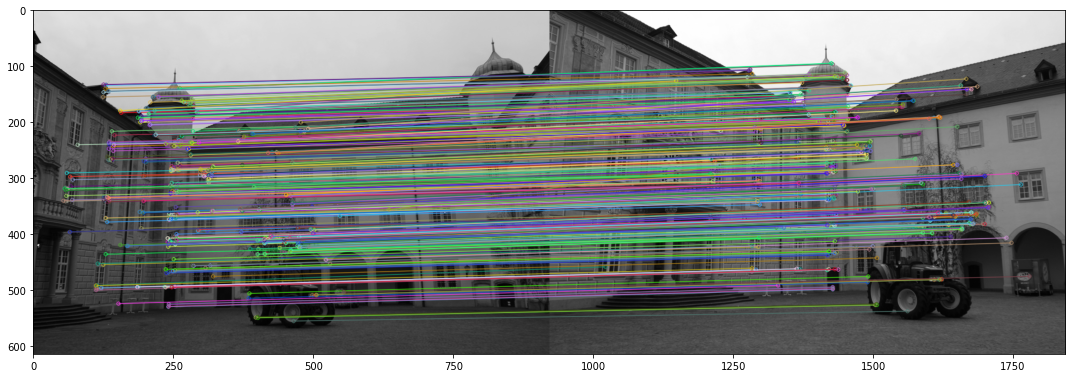

In [ ]:
# Robust estimation of the fundamental matrix #
points1 = []
points2 = []
for m in matches:
    points1.append([kp1[m.queryIdx].pt[0], kp1[m.queryIdx].pt[1], 1])
    points2.append([kp2[m.trainIdx].pt[0], kp2[m.trainIdx].pt[1], 1])
    
points1 = np.asarray(points1)
points1 = points1.T
points2 = np.asarray(points2)
points2 = points2.T

F, indices_inlier_matches = Ransac_fundamental_matrix(points1, points2, 1, 5000)
inlier_matches = itemgetter(*indices_inlier_matches)(matches)

img_12 = cv2.drawMatches(img1,kp1,img2,kp2,inlier_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_12)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

### **1.3 Epipolar lines**

Now the fundamental matrix has been mestimated we are going to display some points and their corresponding epipolar lines.

<span style='color:Green'> - Complete the code that computes the epipolar lines in both images.  </span>

<Figure size 1332x756 with 0 Axes>

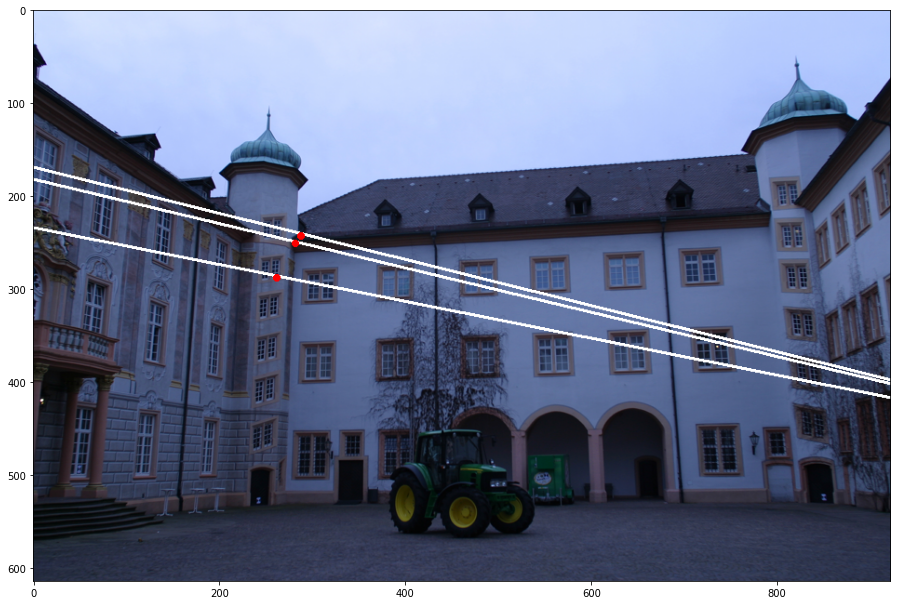

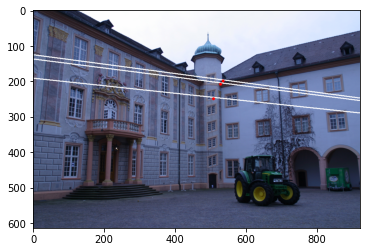

In [ ]:
l2 = F @ points1 # epipolar lines in image 2 (complete) 
l1 = F.T @ points2 # epipolar lines in image 1 (complete) 

# choose three random indices
N = indices_inlier_matches.shape[0]
indices = random.sample(range(1, N), 3)

m1 = indices_inlier_matches[indices[0]]
m2 = indices_inlier_matches[indices[1]]
m3 = indices_inlier_matches[indices[2]]

from PIL import Image, ImageDraw
from utils import line_draw, plot_img

img_path = "./Data/0000_s.png"
I = Image.open(img_path)
size = I.size
canv = ImageDraw.Draw(I)
line_draw(l1[:,m1], canv, size)
line_draw(l1[:,m2], canv, size)
line_draw(l1[:,m3], canv, size)
canv.ellipse((round(points1[0,m1]), round(points1[1,m1]), round(points1[0,m1])+7, round(points1[1,m1])+7), fill = 'red', outline ='red')
canv.ellipse((round(points1[0,m2]), round(points1[1,m2]), round(points1[0,m2])+7, round(points1[1,m2])+7), fill = 'red', outline ='red')
canv.ellipse((round(points1[0,m3]), round(points1[1,m3]), round(points1[0,m3])+7, round(points1[1,m3])+7), fill = 'red', outline ='red')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plot_img(I)

img_path = "./Data/0001_s.png"
I2 = Image.open(img_path)
size = I2.size
canv2 = ImageDraw.Draw(I2)
line_draw(l2[:,m1], canv2, size)
line_draw(l2[:,m2], canv2, size)
line_draw(l2[:,m3], canv2, size)
canv2.ellipse((round(points2[0,m1]), round(points2[1,m1]), round(points2[0,m1])+7, round(points2[1,m1])+7), fill = 'red', outline ='red')
canv2.ellipse((round(points2[0,m2]), round(points2[1,m2]), round(points2[0,m2])+7, round(points2[1,m2])+7), fill = 'red', outline ='red')
canv2.ellipse((round(points2[0,m3]), round(points2[1,m3]), round(points2[0,m3])+7, round(points2[1,m3])+7), fill = 'red', outline ='red')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plot_img(I2)


## **2. Application: Photo-sequencing**

In this part we will compute a simplified version of the algorithm explained in the Photo-sequencing paper [1]. Since we do not have two images taken from roughly the same viewpoint at two different time instants we will manually pick a dynamic point corresponding to a point in a van (identified by index 'idx1') and the projection of its 3D trajectory in the reference image. Then we will compute the projection (to the reference image) of two points on this 3D trajectory at two different time instants (corresponding to the time when the two other provided images where taken). 

[1] T. Basha, Y. Moses, and S. Avidan. Photo Sequencing, International Journal of Computer Vision, 110(3), 2014.

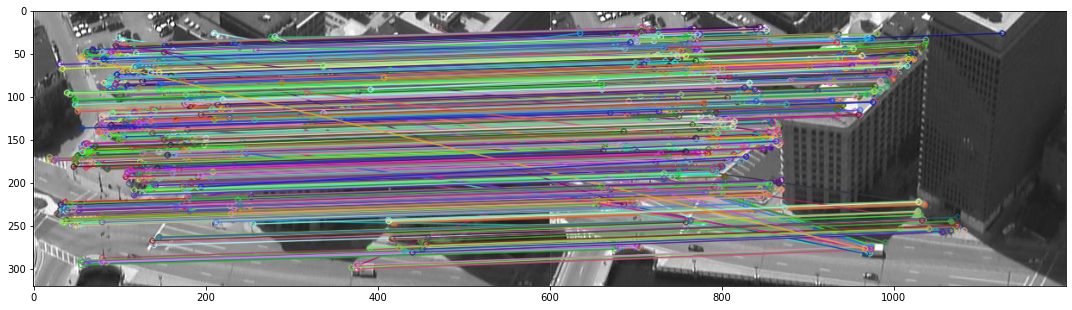

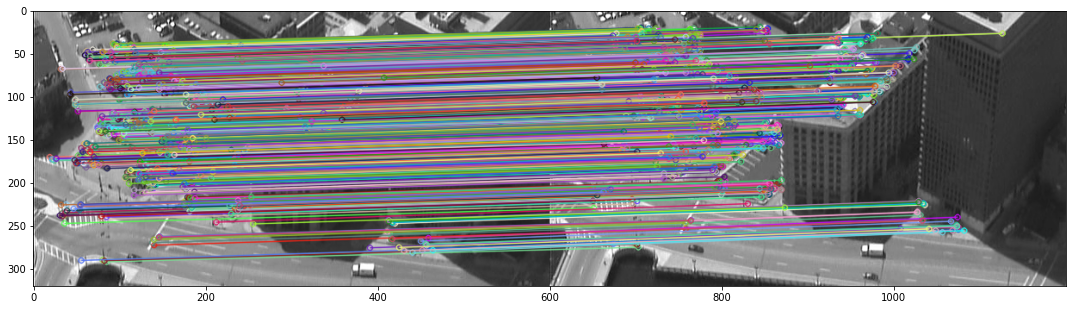

In [ ]:
# Compute fundamental matrix between image 1 and 2 #

# Read images
img1 = cv2.imread('Data/frame_00000.tif',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('Data/frame_00001.tif',cv2.IMREAD_GRAYSCALE)
img1 = img1[400:, :600]
img2 = img2[400:, :600]

# Initiate ORB detector
orb = cv2.ORB_create(nfeatures=4000,scaleFactor =1.1, edgeThreshold = 19, patchSize = 19)
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)
        
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches_12 = bf.match(des1,des2)

# Show matches
img_12 = cv2.drawMatches(img1,kp1,img2,kp2,matches_12,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_12)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

# Robust estimation of the fundamental matrix #
points1 = []
points2 = []
for m in matches_12:
    points1.append([kp1[m.queryIdx].pt[0], kp1[m.queryIdx].pt[1], 1])
    points2.append([kp2[m.trainIdx].pt[0], kp2[m.trainIdx].pt[1], 1])
    
points1 = np.asarray(points1)
points1 = points1.T
points2 = np.asarray(points2)
points2 = points2.T

F, indices_inlier_matches = Ransac_fundamental_matrix(points1, points2, 1, 5000)
inlier_matches_12 = itemgetter(*indices_inlier_matches)(matches_12)

img_12 = cv2.drawMatches(img1,kp1,img2,kp2,inlier_matches_12,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_12)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

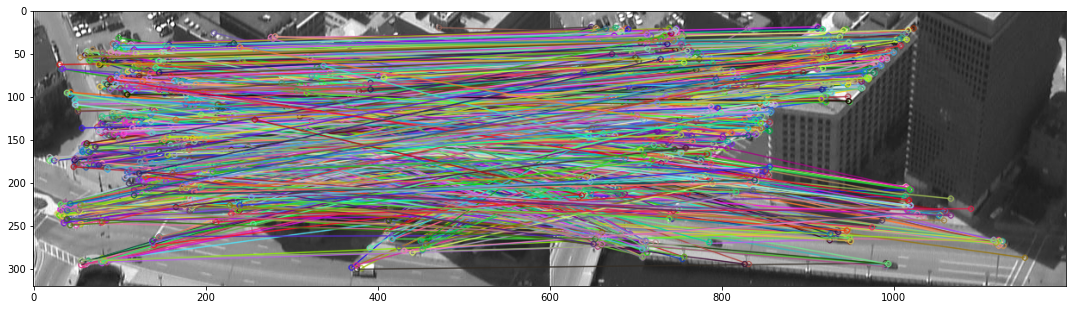

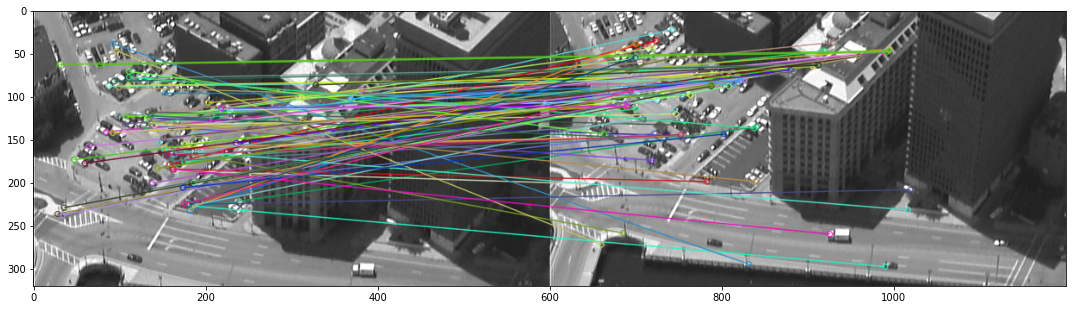

In [ ]:
# Compute fundamental matrix between image 1 and 3 #

# Read images
img3 = cv2.imread('Data/frame_00002.tif',cv2.IMREAD_GRAYSCALE)
img3 = img3[400:, :600]

# find the keypoints and descriptors with ORB
kp3, des3 = orb.detectAndCompute(img3,None)
        
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches_13 = bf.match(des1,des2)

# Show matches 
img_13 = cv2.drawMatches(img1,kp1,img3,kp3,matches_13,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_13)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

# Robust estimation of the fundamental matrix #
points1 = []
points3 = []
for m in matches_13:
    points1.append([kp1[m.queryIdx].pt[0], kp1[m.queryIdx].pt[1], 1])
    points3.append([kp3[m.trainIdx].pt[0], kp3[m.trainIdx].pt[1], 1])
    
points1 = np.asarray(points1)
points1 = points1.T
points3 = np.asarray(points3)
points3 = points3.T

F_13, indices_inlier_matches_13 = Ransac_fundamental_matrix(points1, points3, 1, 5000)
inlier_matches_13 = itemgetter(*indices_inlier_matches_13)(matches_13)

img_13 = cv2.drawMatches(img1,kp1,img3,kp3,inlier_matches_13,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_13)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

<span style='color:Green'> - Complete the code to automatically identify the corresponding point of idx1 in images 2 and 3 (you may use the previously computed matches for that). </span>

<span style='color:Green'> - Complete the code that computes the projection of the van trajectory in image 1. </span>

<span style='color:Green'> - Complete the code that computes the projection of the 3D position of the van in the time instances corresponding to images 2 and 3 (points (x12, y12) and (x13, y13) respectively). </span>

In [ ]:
# Searching for the van point:
idxs = []
th = 50
for m in matches_12:
    dist = np.sqrt((334 - kp1[m.queryIdx].pt[0])**2 + (293 - kp1[m.queryIdx].pt[1])**2)
    if dist < th:
        idxs.append(m.queryIdx)
idxs

[183, 273, 305, 995, 1088, 1672]

<Figure size 1332x756 with 0 Axes>

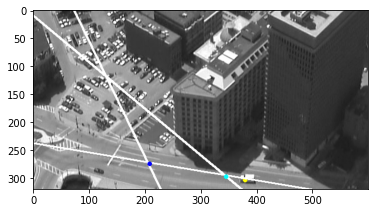

In [ ]:
idx1 = 305
idx2 = [m.trainIdx for m in matches_12 if idx1 == m.queryIdx][0] # complete ...
idx3 = [m.trainIdx for m in matches_13 if idx1 == m.queryIdx][0] # complete ...
           
# Get the point coordinates
(x1, y1) = kp1[idx1].pt
(x2, y2) = kp2[idx2].pt
(x3, y3) = kp3[idx3].pt

point1 = np.array([x1, y1, 1]) # 1st point of the trajectory projected in image 1
point1_2 = np.array([334, 293, 1]) # 2nd point of the trajectory projected in image 1
trajectory = np.cross(point1, point1_2) # complete ...

epiline1 = F.T @ np.array([x2, y2, 1])
epiline2 = F_13.T @ np.array([x3, y3, 1])
point2_p = np.cross(trajectory, epiline1)
point3_p = np.cross(trajectory, epiline2)
x12, y12 = point2_p[:2] / point2_p[2] # complete ...
x13, y13 = point3_p[:2] / point3_p[2] # complete ...

img_path = "Data/frame_00000.tif"
I = Image.open(img_path).convert('RGB')
w, h = I.size
###size = I.size
I2 = I.crop((0, 400, 600, h))
canv2 = ImageDraw.Draw(I2)
canv2.ellipse((x1, y1, x1+7, y1+7), fill = 'yellow', outline ='yellow')
line_draw(trajectory, canv2, size)
line_draw(epiline1, canv2, size)
canv2.ellipse((x12, y12, x12+7, y12+7), fill = 'cyan', outline ='cyan')
line_draw(epiline2, canv2, size)
canv2.ellipse((x13, y13, x13+7, y13+7), fill = 'blue', outline ='blue')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plot_img(I2)            

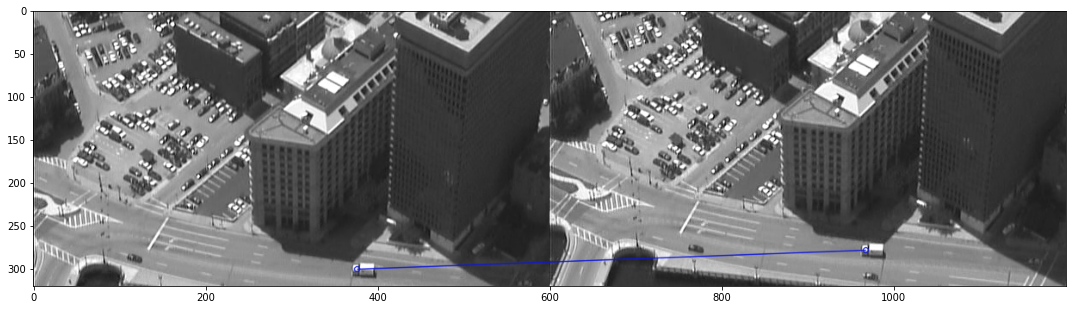

In [ ]:
m_12 = [m for m in matches_12 if idx1 == m.queryIdx][0]
img_12 = cv2.drawMatches(img1,kp1,img2,kp2,[m_12],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_12)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

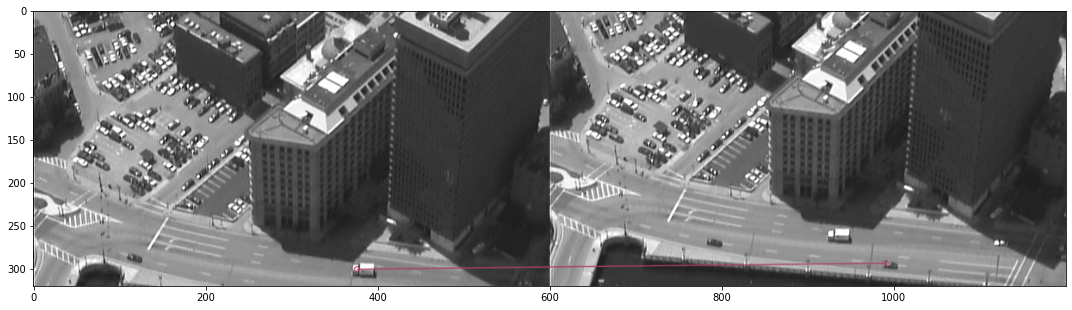

In [ ]:
m_13 = [m for m in matches_13 if idx1 == m.queryIdx][0]
img_13 = cv2.drawMatches(img1,kp1,img3,kp3,[m_13],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_13)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=063a4c15-5348-4903-b64f-c6c6523997bf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>